# Use `Networkit` to speed up calculations

In [1]:
import networkit as nk
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import powerlaw

from utils import plot_powerlaw, show_weight

In [2]:
# Save index of the artists
ARTISTS_BY_INDEX: dict = {}
ARTISTS_BY_NAME: dict = {}

# Reduce graph using `Graph Sampling` and `Edge Shedding`

In [3]:
def update_artists(graph) -> nk.Graph:
    global ARTISTS_BY_INDEX
    global ARTISTS_BY_NAME
    
    artist_by_name = {}
    artist_by_index = {}
    iter = graph.iterNodes()
    G = nk.Graph(weighted=True, directed=False)
    for i, node in enumerate(iter):
        artist = ARTISTS_BY_INDEX[node] # type: ignore
        artist_by_index[i] = artist
        artist_by_name[artist] = i
        G.addNode()
    iter = graph.iterEdges()
    for u, v in iter:
        n_u = artist_by_name[ARTISTS_BY_INDEX[u]] # type: ignore
        n_v = artist_by_name[ARTISTS_BY_INDEX[v]] # type: ignore
        n_weight = graph.weight(u, v)
        G.addEdge(n_u, n_v, n_weight)
    # Update maps
    ARTISTS_BY_INDEX = artist_by_index
    ARTISTS_BY_NAME = artist_by_name
    return G

## graph sampling

In [4]:
def graph_sampling(G, sample_size):
    
    # Calcular el grado de cada nodo
    degrees = {i: G.degree(i) for i in range(G.numberOfNodes())}

    # Crear una lista de nodos y sus grados
    nodes = list(range(G.numberOfNodes()))
    node_degrees = [degrees[n] for n in nodes]

    # Calcular la probabilidad de selección basada en el grado
    total_degree = sum(node_degrees)
    probabilities = [degree / total_degree for degree in node_degrees]

    # Seleccionar nodos de manera aleatoria pero ponderada por su grado
    sampled_nodes = np.random.choice(
        nodes, size=sample_size, replace=False, p=probabilities
    )

    # Crear el subgrafo con los nodos seleccionados
    sampled_graph = nk.graphtools.subgraphFromNodes(G, sampled_nodes)
    
    # Set weights
    iter = sampled_graph.iterEdges()
    for u, v in iter:
        weight = G.weight(u, v)
        if weight == 0:
            continue
        sampled_graph.setWeight(u, v, weight)
    
    # Map graph again
    sampled_graph = update_artists( sampled_graph)
    
    # Mostrar estadísticas del grafo reducido
    print(
        f"Nodos originales: {G.numberOfNodes()}, Nodos reducidos: {sampled_graph.numberOfNodes()}"
    )
    print(
        f"Aristas originales: {G.numberOfEdges()}, Aristas reducidas: {sampled_graph.numberOfEdges()}"
    )
    return sampled_graph

## Edge shedding

In [5]:
def edge_shedding(graph):
    # Indexar edges
    graph.indexEdges()

    # Obtener aristas del grafo con networkit
    betweenness = nk.centrality.Betweenness(graph)
    betweenness.run()
    edge_betweenness = betweenness.edgeScores()

    iter = graph.iterEdges()
    # Obtener aristas con pesos en una línea
    edges = [(u, v, graph.weight(u, v)) for u, v in iter]
    # Asegurarse de que los IDs de las aristas estén dentro del rango
    edges_sorted = sorted(
        edges,
        key=lambda e: (
            edge_betweenness[graph.edgeId(e[0], e[1])]
            if graph.edgeId(e[0], e[1]) < len(edge_betweenness)
            else 0
        ),
        reverse=True,
    )
    p = 0.3  # Proporción de aristas a preservar
    num_edges_to_keep = int(p * graph.numberOfEdges())

    # Crear el grafo reducido
    G_reduced = nk.graph.Graph(weighted=True, directed=False)

    # Agregar las aristas preservadas al grafo reducido
    for i in range(num_edges_to_keep):
        u, v, w = edges_sorted[i]
        G_reduced.addEdge(u, v, w, addMissing=True)
        
    # Eliminar los nodos con degree 0
    G_reduced.indexEdges()
    G_reduced.forNodes(lambda u: G_reduced.removeNode(u) if G_reduced.degree(u) == 0 else None)

    # Map graph again
    G_reduced = update_artists(G_reduced)

    # Mostrar estadísticas del grafo reducido
    print(f"Aristas eliminadas: {len(edges_sorted) - num_edges_to_keep}")
    print(f"Nodos: {G_reduced.numberOfNodes()}, Aristas: {G_reduced.numberOfEdges()}")
    return G_reduced

# Process data

## Read `CSV`'s and join

In [6]:
# read with networkx
filename = f"../datasets/edges/ArtistW.csv"
print(f"Reading {filename}")
G = nx.read_edgelist(
    filename,
    nodetype=str,
    delimiter=";",
    create_using=nx.Graph(),
    data=(('weight', int),) # type: ignore
)

Reading ../datasets/edges/ArtistW.csv


In [7]:
for i,node in enumerate(G):
    ARTISTS_BY_INDEX[i] = node
    ARTISTS_BY_NAME[node] = i

In [8]:
# Create an empty Networkit graph
G_nk = nk.Graph(weighted=True, directed=False)

# Add nodes to the Networkit graph
G_nk.addNodes(G.number_of_nodes())

# Add edges with weights to the Networkit graph
for u, v, data in G.edges(data=True):
    G_nk.addEdge(ARTISTS_BY_NAME[u], ARTISTS_BY_NAME[v], data["weight"])
G = G_nk
del G_nk

In [9]:
# make graph undirected
print(f"Nodes: {G.numberOfNodes()}, Edges: {G.numberOfEdges()}, Self Loops: {G.numberOfSelfLoops()}")
G.removeSelfLoops()
show_weight(G)

Nodes: 20357, Edges: 518214, Self Loops: 2
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 62.418882619468484


Graph


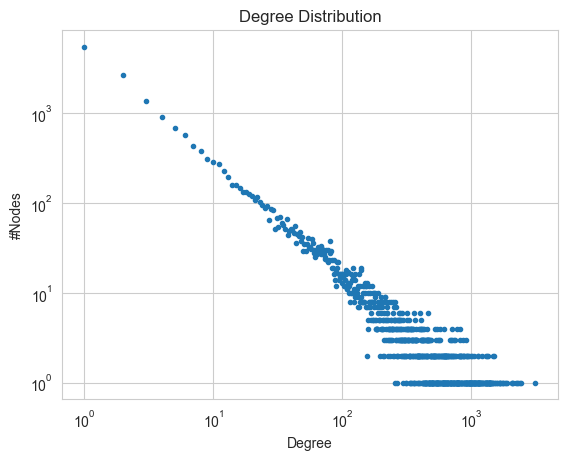

In [10]:
print("Graph")
plot_powerlaw(G)

Graph Sampling
Nodos originales: 20357, Nodos reducidos: 10000
Aristas originales: 518212, Aristas reducidas: 491353
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 64.56157385830554


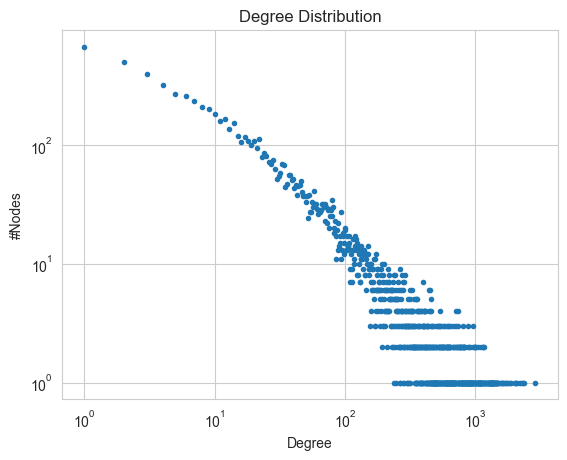

In [11]:
print("Graph Sampling")
G = graph_sampling(G, 10_000)
show_weight(G)
plot_powerlaw(G)

Edge Shedding
Aristas eliminadas: 343948
Nodos: 6178, Aristas: 147405
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 93.70580373800074


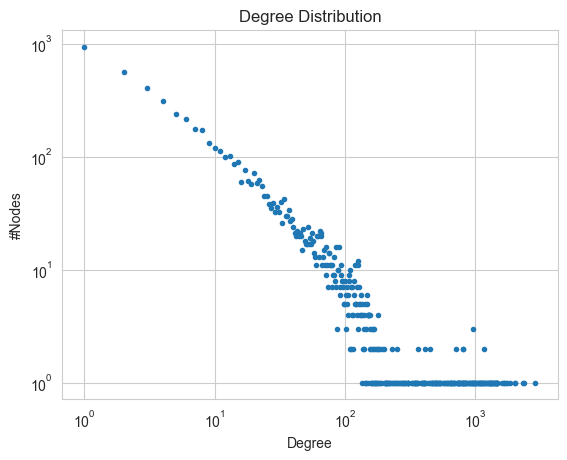

In [12]:
print("Edge Shedding")
G = edge_shedding(G)
show_weight(G)
plot_powerlaw(G)

# Plot Graph

In [13]:
def generate_rgb(seed: int) -> str:
    # return "#xxxxx"
    random.seed(seed)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"

In [14]:
# Generate g with weights 
g = nx.Graph()
for u, v, data in G.iterEdgesWeights():
    g.add_edge(u, v, weight=data)

In [15]:
nodes_size = [g.degree(node) * 1.65 for node in g.nodes()] # type: ignore

In [16]:
hubs, _ = nx.hits(g, max_iter=100, tol=1e-08, normalized=True)
# hubs = set(hubs.keys())

# Ordenar los nodos por sus puntajes de hub en orden descendente
sorted_hubs = sorted(hubs.items(), key=lambda item: item[1], reverse=True)

# Definir cuántos hubs principales seleccionar (ejemplo: top 3 hubs)
top_n = 10
top_hubs = sorted_hubs[:top_n]

# Mostrar los principales hubs
print(f"Top {top_n} Hubs:")
for node, score in top_hubs:
    print(f"Nodo {node}: Puntaje de hub {score}")

Top 10 Hubs:
Nodo 209: Puntaje de hub 0.04140248716709974
Nodo 222: Puntaje de hub 0.021897205272647473
Nodo 536: Puntaje de hub 0.017639131521221423
Nodo 534: Puntaje de hub 0.017441561448222367
Nodo 210: Puntaje de hub 0.016969013663487506
Nodo 217: Puntaje de hub 0.016455600594523365
Nodo 107: Puntaje de hub 0.015704413356690188
Nodo 208: Puntaje de hub 0.014999989359646549
Nodo 227: Puntaje de hub 0.014076809173780156
Nodo 202: Puntaje de hub 0.01346325942772179


In [17]:
# see artist with hubs
print("Top Hubs")
for node, score in top_hubs:
    print(f"Node: {node}, Score: {score}")
    print(f"Artist: { ARTISTS_BY_INDEX[node]}")

Top Hubs
Node: 209, Score: 0.04140248716709974
Artist: Drake
Node: 222, Score: 0.021897205272647473
Artist: Kendrick_Lamar
Node: 536, Score: 0.017639131521221423
Artist: Future
Node: 534, Score: 0.017441561448222367
Artist: Kanye_West
Node: 210, Score: 0.016969013663487506
Artist: Big_Sean
Node: 217, Score: 0.016455600594523365
Artist: J._Cole
Node: 107, Score: 0.015704413356690188
Artist: Rihanna
Node: 208, Score: 0.014999989359646549
Artist: Migos
Node: 227, Score: 0.014076809173780156
Artist: Rae_Sremmurd
Node: 202, Score: 0.01346325942772179
Artist: Post_Malone


In [18]:
hubs = [node for node, _ in top_hubs]

In [19]:
nodes_color = [generate_rgb(100) if node in hubs else generate_rgb(120)  for node in g.nodes()]

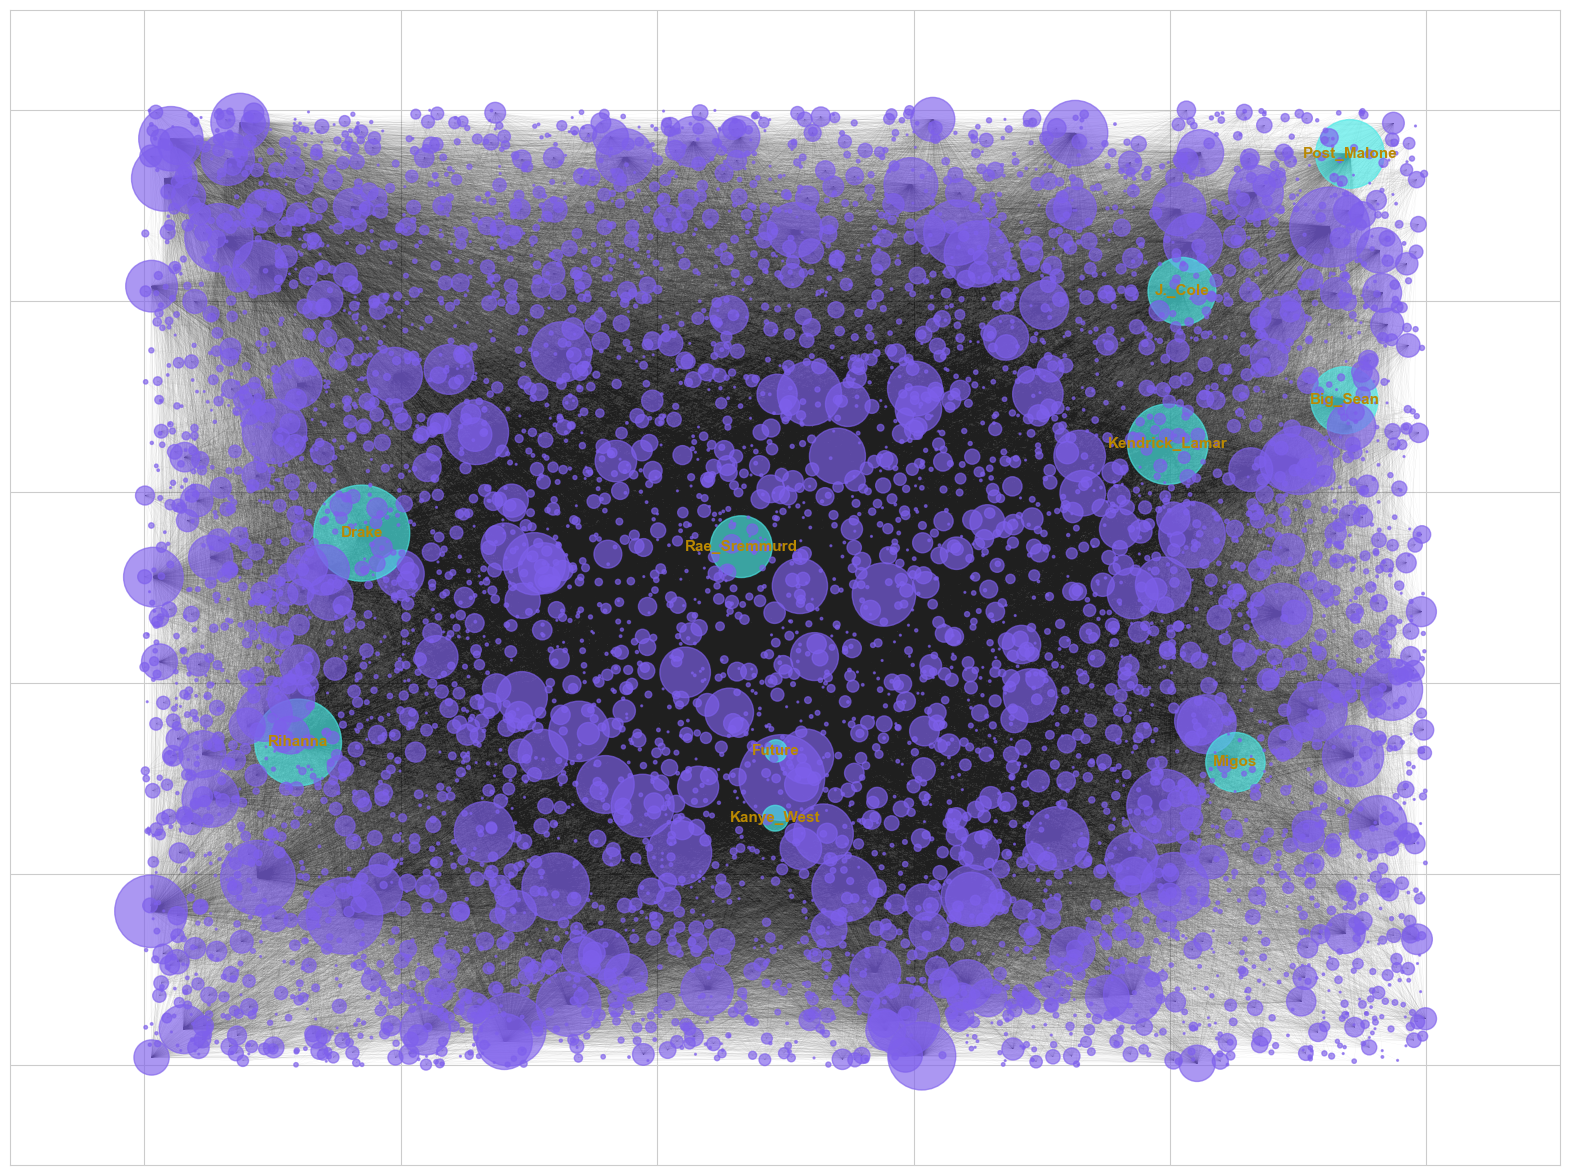

In [20]:
# Aumentar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Calcular la posición de los nodos
pos = nx.random_layout(g, seed=42)

# Dibujar los nodos
nx.draw_networkx_nodes(g, pos, node_size=nodes_size, node_color=nodes_color, alpha=0.65)  # type: ignore

# Dibujar las aristas
nx.draw_networkx_edges(g, pos, width=0.1, alpha=0.1, edge_color="#1f1f1f")

# Dibujar etiquetas para los hubs
nx.draw_networkx_labels(
    g,
    pos,
    labels={node: ARTISTS_BY_INDEX[node] for node in hubs},
    font_size=11,
    font_color="#ba8902",
    font_weight="bold",
)

# Mostrar la gráfica
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


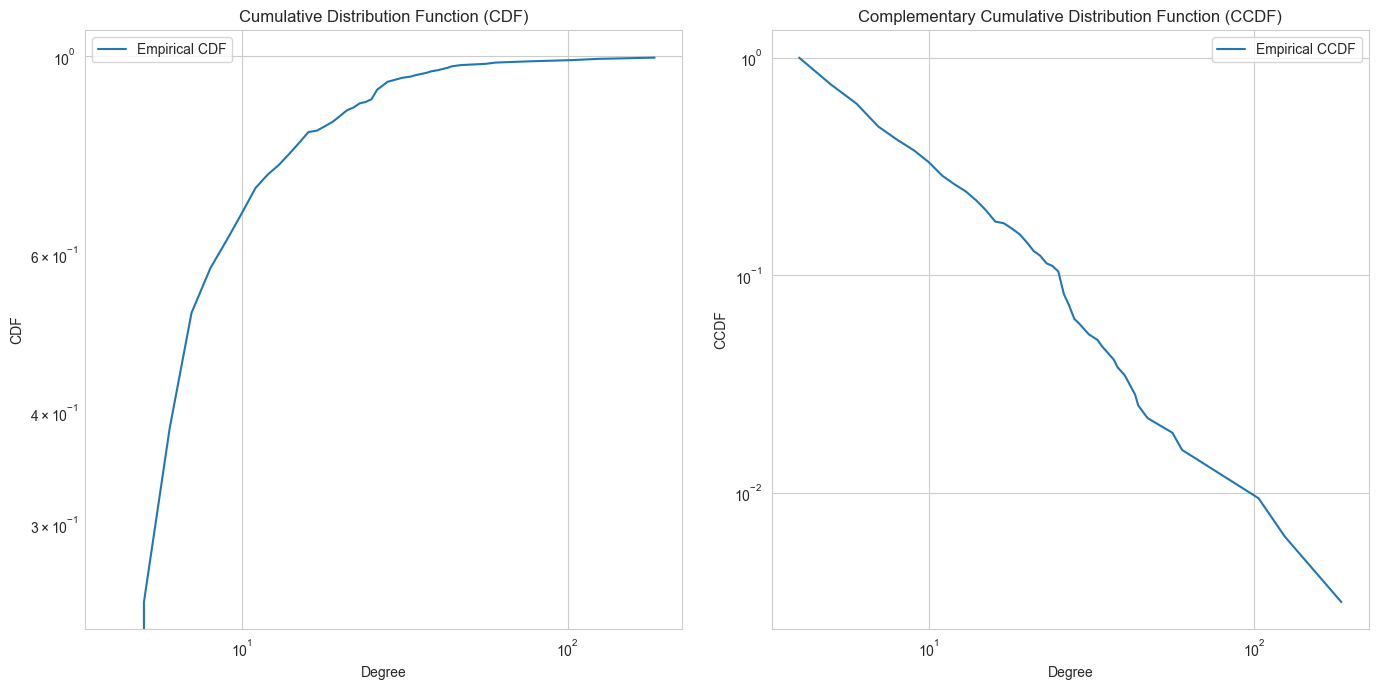

In [21]:
def plot_dist(G):
    M = nx.to_scipy_sparse_array(G)  # Convertimos el grafo a una matriz dispersa de scipy
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0)  # Suma de los grados de entrada
    degree = np.bincount(indegrees.astype(int))  # Asegúrate de convertir los grados a enteros
    fit = powerlaw.Fit(np.array(degree), fit_method="KS")

    fig = plt.figure(figsize=(20, 7))

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf(label="Empirical CDF")
    plt.xlabel("Degree")
    plt.ylabel("CDF")
    plt.title("Cumulative Distribution Function (CDF)")
    plt.legend()

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf(label="Empirical CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF")
    plt.title("Complementary Cumulative Distribution Function (CCDF)")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Ahora puedes llamar a la función con tu grafo g
plot_dist(g)

In [22]:
# save graph
filename = f"../datasets/edges/ArtistW_sample.csv"
print(f"Saving {filename}")
nx.write_edgelist(
    g,
    filename,
    delimiter=";",
    data=["weight"],
    encoding="utf-8",
)
# save artist index in json
filename = f"../datasets/edges/ArtistW_index.json"
print(f"Saving {filename}")
import json

with open(filename, "w") as f:
    json.dump(ARTISTS_BY_INDEX, f)
    
# Saave artist name in json
filename = f"../datasets/edges/ArtistW_name.json"
print(f"Saving {filename}")
with open(filename
            , "w") as f:
        json.dump(ARTISTS_BY_NAME, f)

Saving ../datasets/edges/ArtistW_sample.csv
Saving ../datasets/edges/ArtistW_index.json
Saving ../datasets/edges/ArtistW_name.json


## See comunity structure

In [65]:
# find comunities with Networkit
print("Community Detection")
# Crear una instancia del algoritmo de detección de comunidades
algo = nk.community.LouvainMapEquation(G)

# Detectar comunidades usando el algoritmo especificado
communities= nk.community.detectCommunities(G,algo=algo)

# Obtener los nodos de cada comunidad
for i, community in enumerate(communities.getSubsetIds()):
    nodes = communities.getMembers(community)
    print(f"Comunidad {i}: {nodes}")

Community Detection
Communities detected in 0.02000 [s]
solution properties:
-------------------  --------------
# communities          14
min community size     10
max community size   3109
avg. community size   441.286
imbalance               7.03394
edge cut                2.15367e+06
edge cut (portion)     14.6106
modularity              0.265088
-------------------  --------------
Comunidad 0: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 33, 34, 73, 74, 84, 88, 93, 94, 95, 96, 97, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 117, 122, 123, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 139, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 162, 163, 164, 165, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 245, 247, 252, 256, 263,

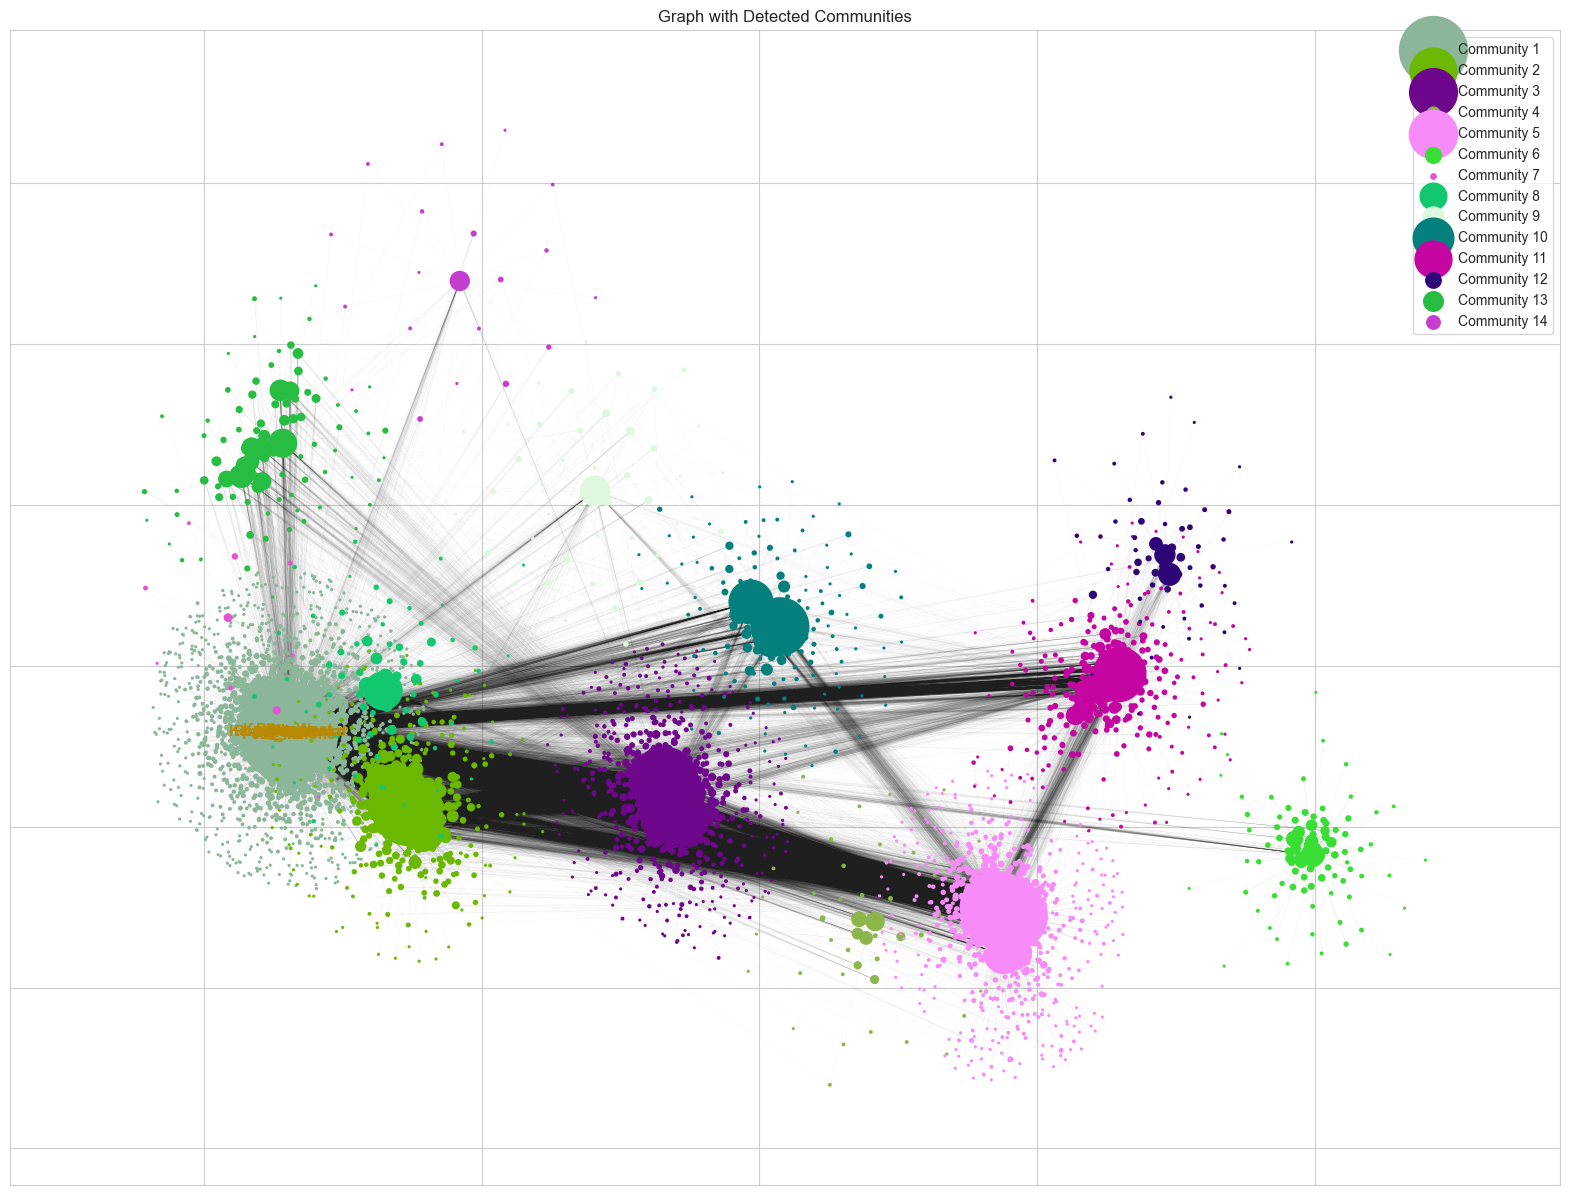

In [105]:
def plot_communities(G, communities):
    pos = {}
    offset_x = 1.5  # Separación horizontal entre comunidades
    offset_y = 1.5  # Separación vertical entre comunidades
    jitter_strength = 0.65  # Fuerza del ruido aleatorio (jitter)
    cols = 6  # Número de columnas para distribuir las comunidades

    for i, community in enumerate(communities.getSubsetIds()):
        nodes = communities.getMembers(community)
        subgraph = G.subgraph(nodes)
        sub_pos = nx.spring_layout(subgraph, seed=42, weight="weight")

        # Calcular desplazamiento en la cuadrícula
        row = i // cols
        col = i % cols
        offset = np.array([col * offset_x, row * offset_y])

        # Agregar jitter aleatorio para romper la regularidad
        jitter = np.random.uniform(-jitter_strength, jitter_strength, 2)
        offset += jitter

        # Offset positions to separate communities
        for node in sub_pos:
            sub_pos[node] += offset

        pos.update(sub_pos)

    plt.figure(figsize=(20, 15))
    colors = [generate_rgb(i) for i in range(communities.numberOfSubsets())]

    for i, community in enumerate(communities.getSubsetIds()):
        nodes = communities.getMembers(community)
        nodes_size = [G.degree(node) * 1.65 for node in nodes]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_color=[colors[i]],
            node_size=nodes_size,
            label=f"Community {i+1}",
        )

    nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.1, edge_color="#1f1f1f")

    # Dibujar etiquetas para los hubs
    nx.draw_networkx_labels(
        G,
        pos,
        labels={
            node: ARTISTS_BY_INDEX[node] for node in hubs
        },  # Debes tener una variable hubs y ARTISTS_BY_INDEX
        font_size=11,
        font_color="#ba8902",
        font_weight="bold",
    )

    plt.legend()
    plt.title("Graph with Detected Communities")
    plt.show()

# Llama a la función
plot_communities(g, communities)

In [98]:
nodes = list(communities.getMembers(11))
for node in nodes[:10]:
    print(f"{ARTISTS_BY_INDEX[node]}")

Charlie_Robison
Randy_Rogers_Band
Zane_Williams
Kevin_Fowler
Jon_Wolfe
Bart_Crow
Casey_Donahew
Honeybrowne
Parker_McCollum
Blackberry_Smoke
